In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.base import clone
import seaborn as sns
import matplotlib.pyplot as plt
import gpplot as gpp

In [2]:
cleaned_data = pd.read_csv('../../Data/cleanedData/CombinedCleanedDatasets.csv')

#alter chromosome notation to be compatible chromatin accessibility files
cleaned_data['chromosome'] = cleaned_data['chromosome'].replace('chr24','chrY')
cleaned_data['chromosome'] = cleaned_data['chromosome'].replace('chr23','chrX')
cleaned_data

,Target Gene Symbol,chromosome,sgRNA Sequence,sgRNA Context Sequence,sgRNA 'Cut' Position,Strand of Target,Strand of sgRNA,TSS Position,sgRNA 'Cut' Site TSS Offset,Phenotype scores-ave_Rep1_Rep2,...,condition,Domain,DataSet,zscoreRelativeNC_signed,Avg_LFC_signed,z_scored_avg_lfc,rs3ChenSeqScore,cellDomainDataSet,z_score,signed_zscore
0,LARS2,chr3,AAAAAAAAAACAGGACACAG,CAGAAAAAAAAAAACAGGACACAGGGGAGA,45389244.0,+,-,45388577.0,667.0,NaN,...,A549,Kox1,InHouse,NaN,NaN,-0.398339,0.013999,A549_Kox1_InHouse,-0.398339,0.398339
1,LARS2,chr3,AAAAAAAAAACAGGACACAG,CAGAAAAAAAAAAACAGGACACAGGGGAGA,45389244.0,+,-,45388577.0,667.0,NaN,...,A549,Zim3,InHouse,NaN,NaN,-0.841793,0.013999,A549_Zim3_InHouse,-0.841793,0.841793
2,LARS2,chr3,AAAAAAAAAACAGGACACAG,CAGAAAAAAAAAAACAGGACACAGGGGAGA,45389244.0,+,-,45388577.0,667.0,NaN,...,HCT116,Zim3,InHouse,NaN,NaN,-0.992358,0.013999,HCT116_Zim3_InHouse,-0.992358,0.992358
3,COQ2,chr4,AAAAAAAAAAGGGCACCAAG,ATAAAAAAAAAAAAGGGCACCAAGTGGCCA,83285687.0,-,+,83284798.0,-888.0,NaN,...,A549,Kox1,InHouse,NaN,NaN,0.044728,-0.401549,A549_Kox1_InHouse,0.044728,-0.044728
4,COQ2,chr4,AAAAAAAAAAGGGCACCAAG,ATAAAAAAAAAAAAGGGCACCAAGTGGCCA,83285687.0,-,+,83284798.0,-888.0,NaN,...,A549,Zim3,InHouse,NaN,NaN,-0.190308,-0.401549,A549_Zim3_InHouse,-0.190308,0.190308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257411,WDR11,chr10,gctaggacctctactacaatgaa,GGCTAGGACCTCTACTACAATGAATGGGAG,120855890.0,+,+,120851363.0,4527.0,NaN,...,K562,Kox1,Gilbert,0.387317,0.354061,NaN,0.382810,K562_Kox1_Gilbert,0.387317,0.387317
257412,WDR11,chr10,gctaggacctctactacaatgaat,GCTAGGACCTCTACTACAATGAATGGGAGA,120855891.0,+,+,120851363.0,4528.0,NaN,...,K562,Kox1,Gilbert,-0.782858,-0.048063,NaN,0.654478,K562_Kox1_Gilbert,-0.782858,-0.782858
257413,WDR11,chr10,gtctttcatcaagtctgatgta,CAGTCTTTCATCAAGTCTGATGTAAGGTAT,120855971.0,+,+,120851363.0,4608.0,NaN,...,K562,Kox1,Gilbert,1.429277,0.712125,NaN,0.076554,K562_Kox1_Gilbert,1.429277,1.429277
257414,WDR11,chr10,gtaggtccaagtttcagtc,TTTATGTAGGTCCAAGTTTCAGTCTGGTAT,120856094.0,+,+,120851363.0,4731.0,NaN,...,K562,Kox1,Gilbert,0.553328,0.411110,NaN,0.717680,K562_Kox1_Gilbert,0.553328,0.553328


In [3]:
#unique context sequences per dataset?
cleaned_data.groupby('cellDomainDataSet')['sgRNA Context Sequence'].nunique()

cellDomainDataSet
A549_Kox1_InHouse      42570
A549_Zim3_InHouse      42609
HCT116_Kox1_InHouse    42609
HCT116_Zim3_InHouse    42544
K562_Kox1_Gilbert      18509
K562_Kox1_Nunez        68575
Name: sgRNA Context Sequence, dtype: int64

Since we eventually want to average scores for context sequences screened with the same domain (so that the model remains cell line agnostic), we only want to keep context sequences present in all 4 of our datasets.

In [4]:
#read in z-scored in-house data for context sequences present in all 4 datasets
inHouseDatasetsCombined = pd.read_csv('../../Data/primaryLibrary/inHouseDatasetsCombined.csv')
cleaned_data_inhouse = cleaned_data[cleaned_data['sgRNA Context Sequence'].isin(inHouseDatasetsCombined['sgRNA Context Sequence'])]
cleaned_data_other = cleaned_data[cleaned_data['DataSet'] != 'InHouse']
cleaned_data = pd.concat([cleaned_data_inhouse,cleaned_data_other]).drop_duplicates().reset_index(drop=True)
cleaned_data

,Target Gene Symbol,chromosome,sgRNA Sequence,sgRNA Context Sequence,sgRNA 'Cut' Position,Strand of Target,Strand of sgRNA,TSS Position,sgRNA 'Cut' Site TSS Offset,Phenotype scores-ave_Rep1_Rep2,...,condition,Domain,DataSet,zscoreRelativeNC_signed,Avg_LFC_signed,z_scored_avg_lfc,rs3ChenSeqScore,cellDomainDataSet,z_score,signed_zscore
0,COPS3,chr17,AAAAAAAAAGCCGTGTGAGC,AAAAAAAAAAAAAGCCGTGTGAGCTGGCGG,17280422.0,-,+,17281246.0,825.0,NaN,...,A549,Kox1,InHouse,NaN,NaN,-0.181286,-0.235456,A549_Kox1_InHouse,-0.181286,0.181286
1,COPS3,chr17,AAAAAAAAAGCCGTGTGAGC,AAAAAAAAAAAAAGCCGTGTGAGCTGGCGG,17280422.0,-,+,17281246.0,825.0,NaN,...,A549,Zim3,InHouse,NaN,NaN,-1.270512,-0.235456,A549_Zim3_InHouse,-1.270512,1.270512
2,COPS3,chr17,AAAAAAAAAGCCGTGTGAGC,AAAAAAAAAAAAAGCCGTGTGAGCTGGCGG,17280422.0,-,+,17281246.0,825.0,NaN,...,HCT116,Kox1,InHouse,NaN,NaN,-0.929032,-0.235456,HCT116_Kox1_InHouse,-0.929032,0.929032
3,COPS3,chr17,AAAAAAAAAGCCGTGTGAGC,AAAAAAAAAAAAAGCCGTGTGAGCTGGCGG,17280422.0,-,+,17281246.0,825.0,NaN,...,HCT116,Zim3,InHouse,NaN,NaN,-1.178776,-0.235456,HCT116_Zim3_InHouse,-1.178776,1.178776
4,YEATS4,chr12,AAAAAAAAATTAACGTGCCA,AAAAAAAAAAAAATTAACGTGCCAGGGGCT,69360660.0,+,-,69359744.0,916.0,NaN,...,A549,Kox1,InHouse,NaN,NaN,-0.767487,-1.194224,A549_Kox1_InHouse,-0.767487,0.767487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255495,WDR11,chr10,gctaggacctctactacaatgaa,GGCTAGGACCTCTACTACAATGAATGGGAG,120855890.0,+,+,120851363.0,4527.0,NaN,...,K562,Kox1,Gilbert,0.387317,0.354061,NaN,0.382810,K562_Kox1_Gilbert,0.387317,0.387317
255496,WDR11,chr10,gctaggacctctactacaatgaat,GCTAGGACCTCTACTACAATGAATGGGAGA,120855891.0,+,+,120851363.0,4528.0,NaN,...,K562,Kox1,Gilbert,-0.782858,-0.048063,NaN,0.654478,K562_Kox1_Gilbert,-0.782858,-0.782858
255497,WDR11,chr10,gtctttcatcaagtctgatgta,CAGTCTTTCATCAAGTCTGATGTAAGGTAT,120855971.0,+,+,120851363.0,4608.0,NaN,...,K562,Kox1,Gilbert,1.429277,0.712125,NaN,0.076554,K562_Kox1_Gilbert,1.429277,1.429277
255498,WDR11,chr10,gtaggtccaagtttcagtc,TTTATGTAGGTCCAAGTTTCAGTCTGGTAT,120856094.0,+,+,120851363.0,4731.0,NaN,...,K562,Kox1,Gilbert,0.553328,0.411110,NaN,0.717680,K562_Kox1_Gilbert,0.553328,0.553328


In [5]:
#check that unique number of context sequences per dataset is now same for InHouse datasets regardless of domain
cleaned_data.groupby('cellDomainDataSet')['sgRNA Context Sequence'].nunique()

cellDomainDataSet
A549_Kox1_InHouse      42104
A549_Zim3_InHouse      42104
HCT116_Kox1_InHouse    42104
HCT116_Zim3_InHouse    42104
K562_Kox1_Gilbert      18509
K562_Kox1_Nunez        68575
Name: sgRNA Context Sequence, dtype: int64

In [6]:
#normalize for gene essentiality by z-scoring guide z-scores within the gene targeted and dataset
zscore_scaler = preprocessing.StandardScaler()
cleaned_data['doubleZscore'] = cleaned_data.groupby(['Target Gene Symbol','cellDomainDataSet'])['signed_zscore'].transform(lambda x: clone(zscore_scaler).fit_transform(x.to_frame())[:, 0])

/var/folders/mj/lhpd16ys0cx2wkbhm7s0nfcm0000gp/T/ipykernel_40900/1506836799.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


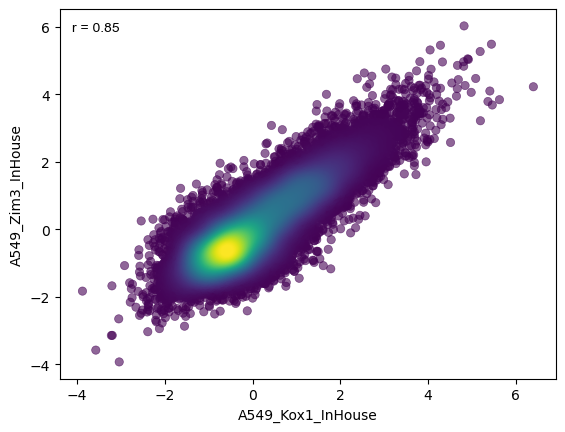

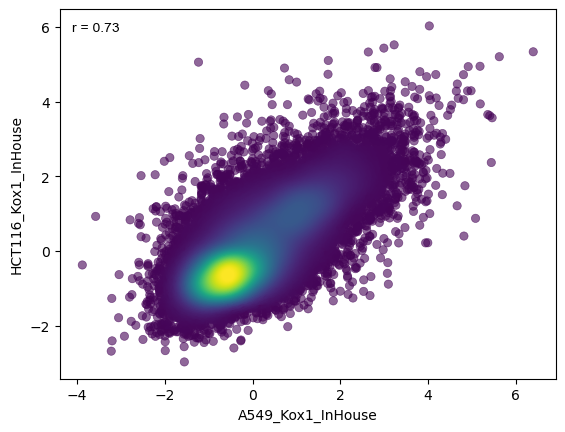

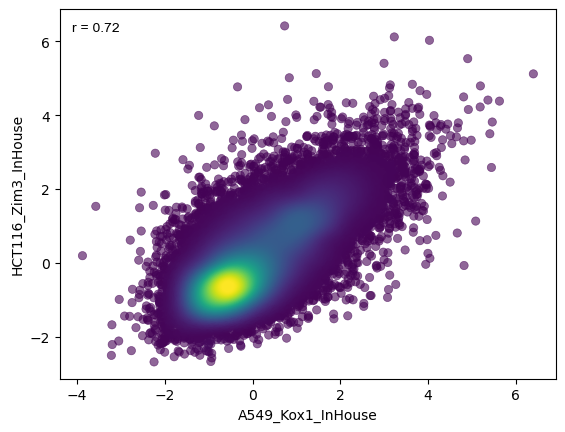

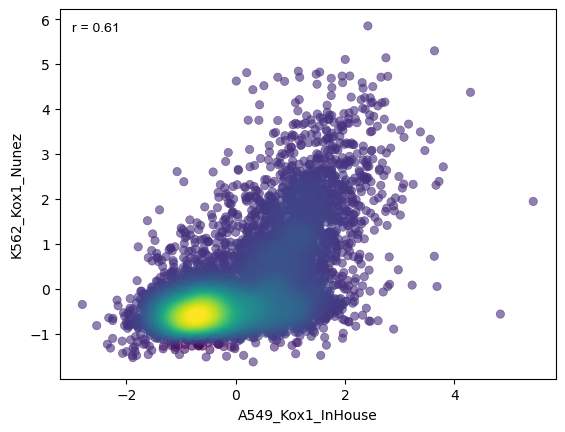

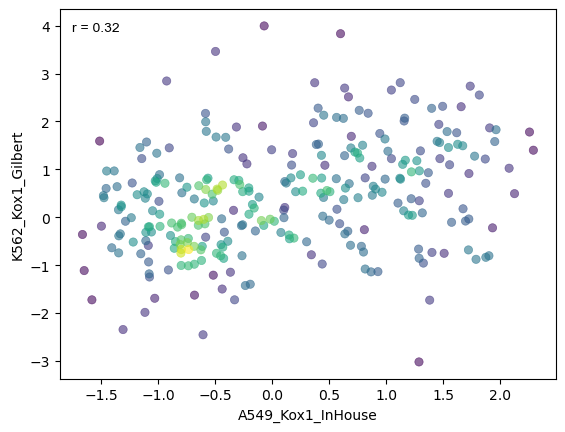

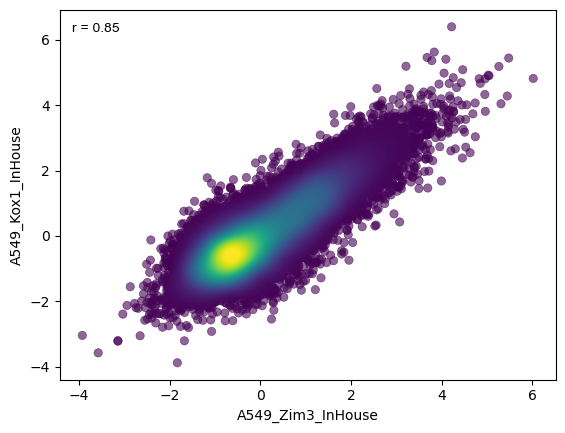

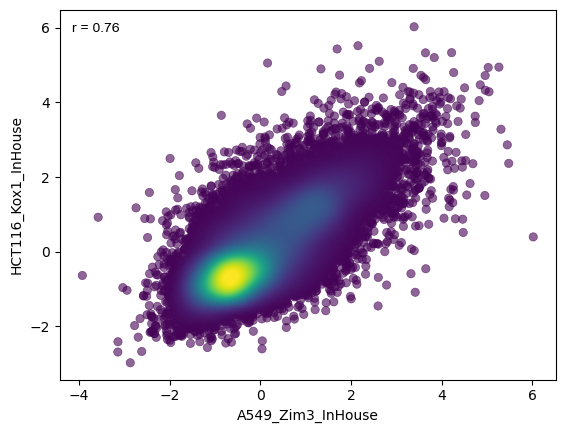

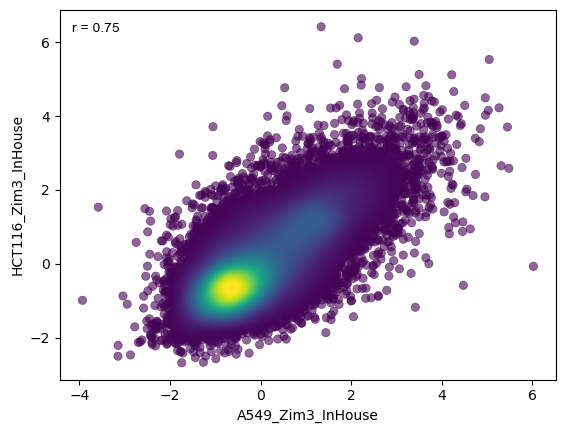

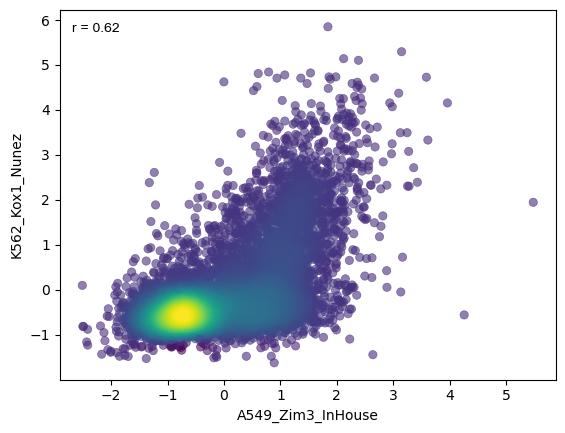

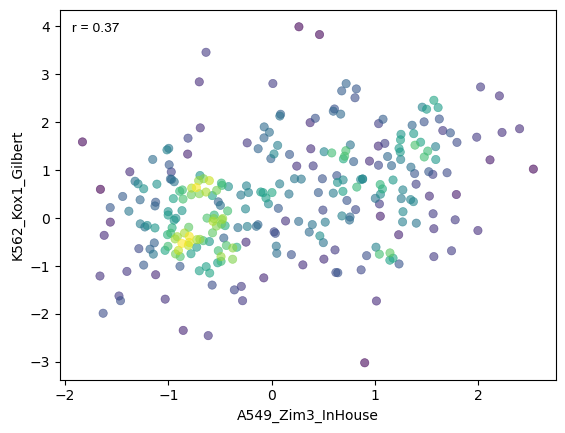

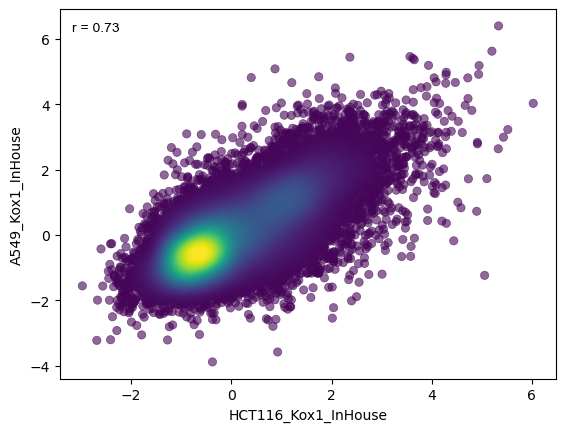

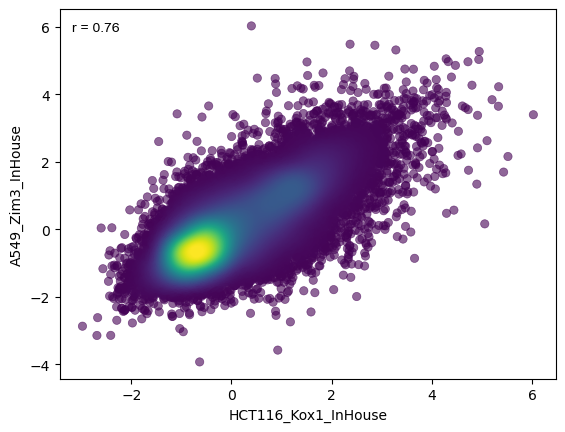

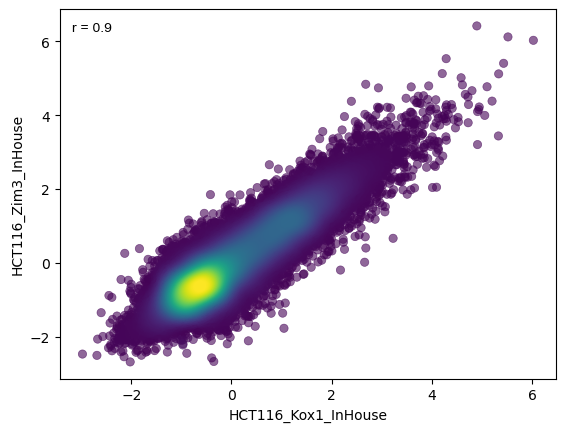

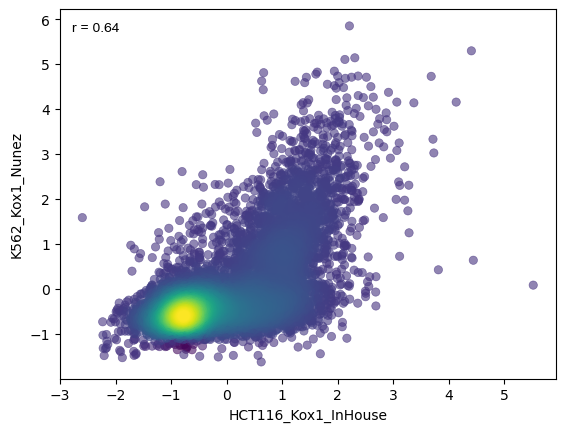

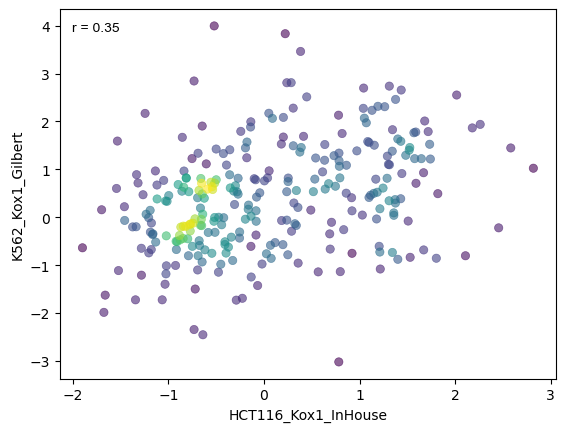

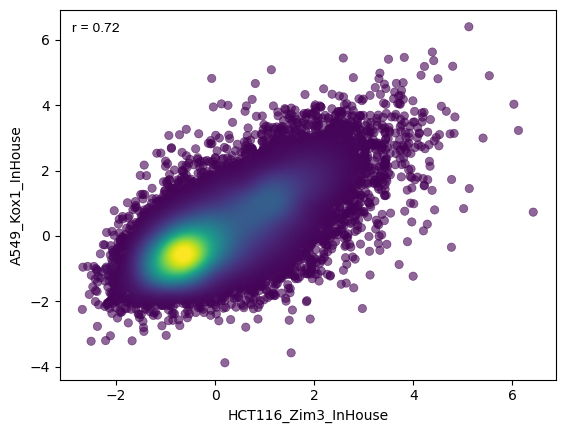

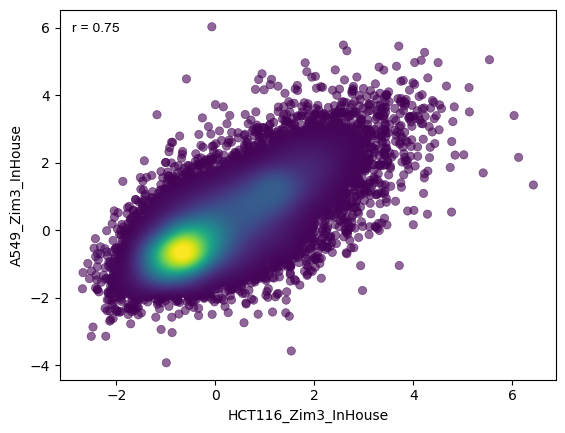

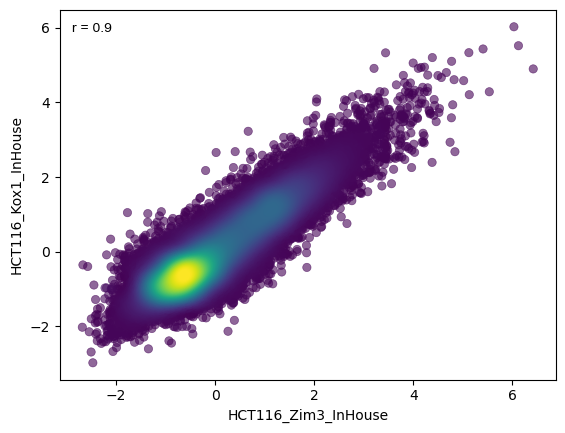

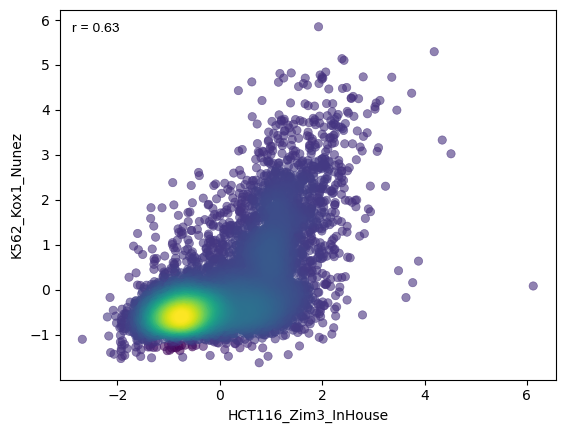

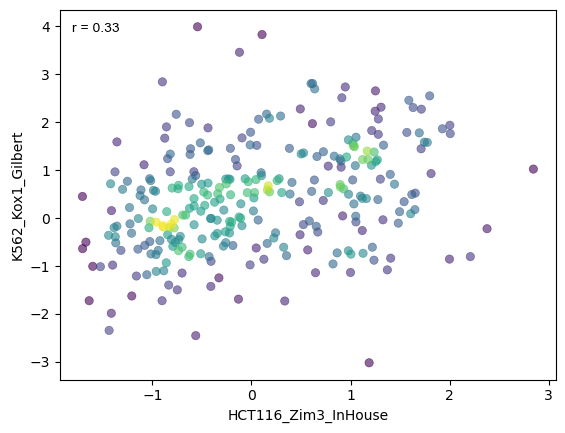

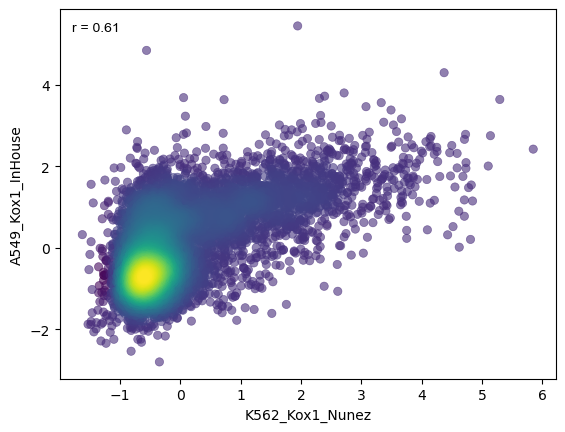

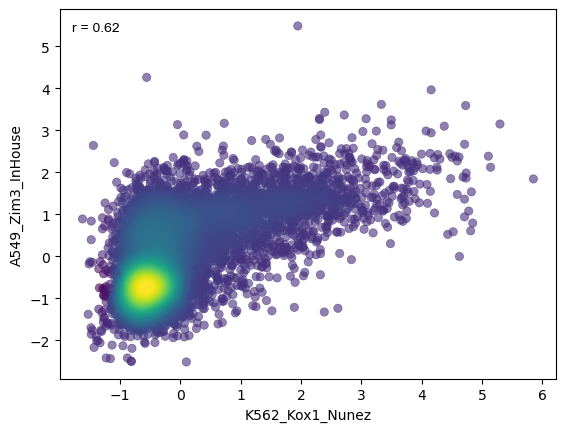

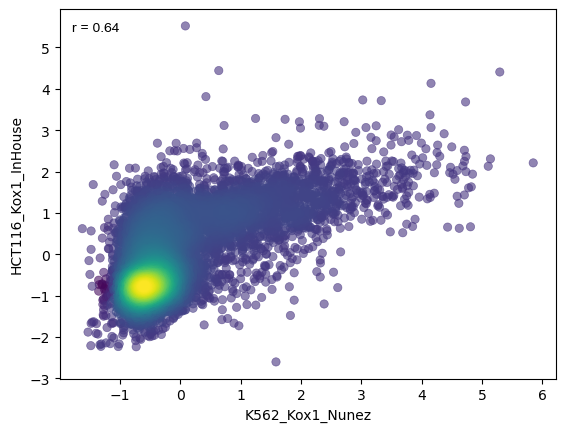

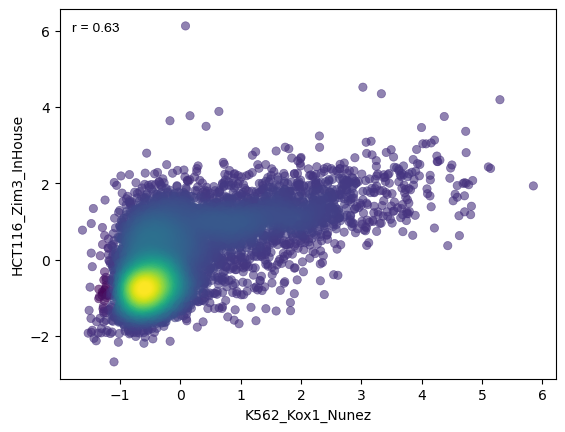

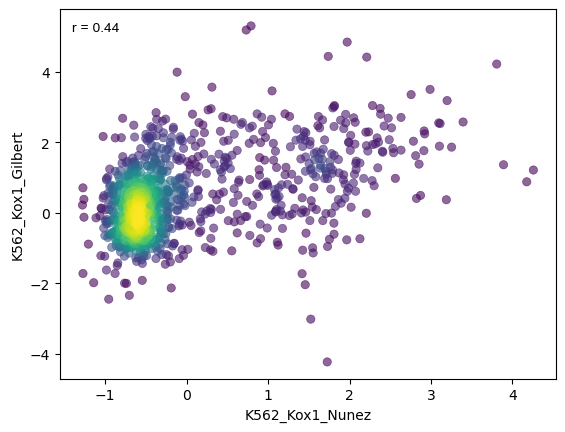

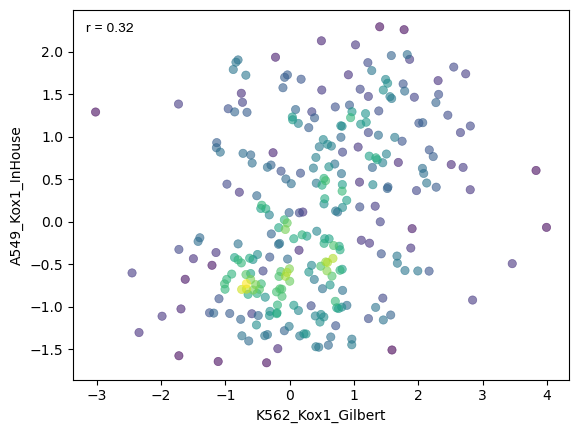

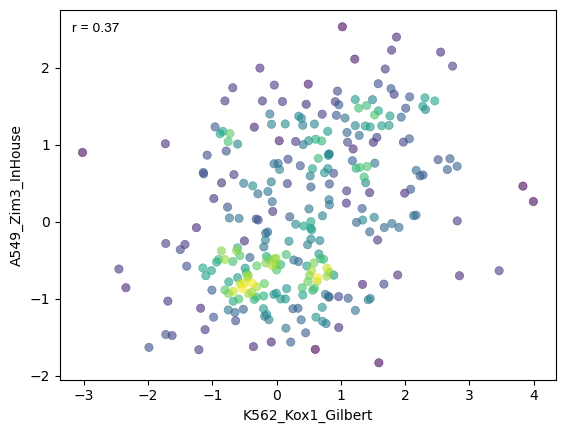

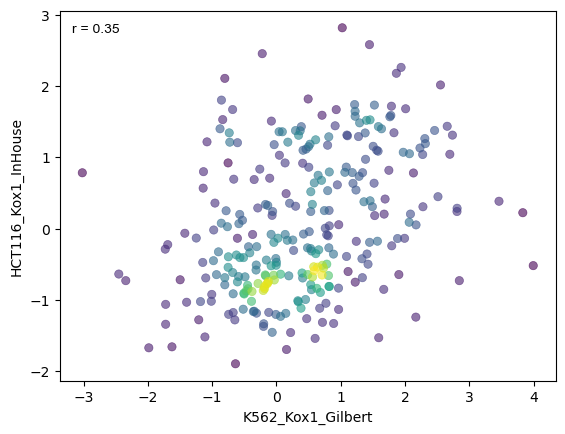

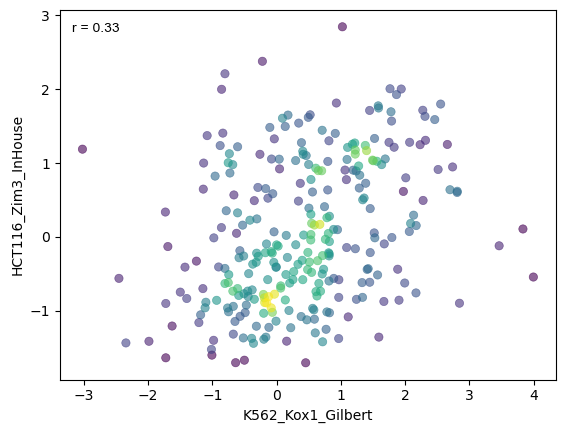

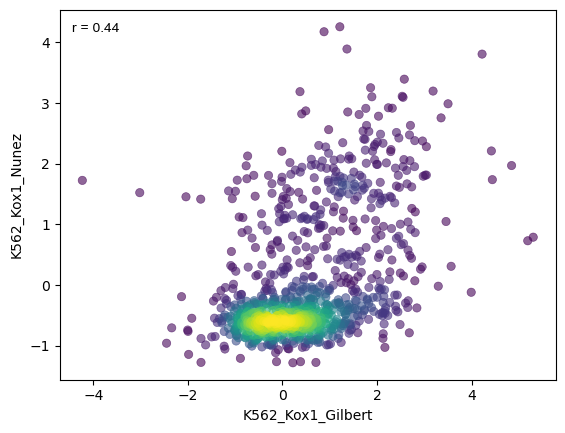

In [7]:
#confirm that guides shared between multiple datasets have positively correlated z-scores
transformed_pivoted = cleaned_data.pivot(index = ['sgRNA Context Sequence','Target Gene Symbol'],
                                         columns = 'cellDomainDataSet', values = 'doubleZscore').reset_index()
for screen1 in cleaned_data['cellDomainDataSet'].unique():
    for screen2 in cleaned_data['cellDomainDataSet'].unique():
        if screen1 != screen2:
            plot_df = transformed_pivoted[[screen1,screen2]].dropna()
            plt.figure()
            gpp.point_densityplot(data = plot_df, x = screen1, y = screen2)
            gpp.add_correlation(data = plot_df, x = screen1, y = screen2)

In [8]:
#average z-scores for same guide screened with same domain
cleaned_data_average_zz = cleaned_data.groupby(['Target Gene Symbol', 'sgRNA Context Sequence', 'Domain', 'Strand of Target',
                                                'Strand of sgRNA', 'chromosome', 'sgRNA \'Cut\' Position', 'TSS Position',
                                                'sgRNA \'Cut\' Site TSS Offset','rs3ChenSeqScore'])['doubleZscore'].mean().reset_index()
cleaned_data_average_zz

,Target Gene Symbol,sgRNA Context Sequence,Domain,Strand of Target,Strand of sgRNA,chromosome,sgRNA 'Cut' Position,TSS Position,sgRNA 'Cut' Site TSS Offset,rs3ChenSeqScore,doubleZscore
0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,Kox1,+,+,chr17,36949636.0,36948955.0,681.0,0.517537,-0.169142
1,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,Zim3,+,+,chr17,36949636.0,36948955.0,681.0,0.517537,-0.340682
2,AATF,AAACTTGGTGCTCGGCTGGATGGGCGGAAC,Kox1,+,+,chr17,36949430.0,36948955.0,475.0,0.011229,0.335486
3,AATF,AAACTTGGTGCTCGGCTGGATGGGCGGAAC,Zim3,+,+,chr17,36949430.0,36948955.0,475.0,0.011229,0.480443
4,AATF,AAAGAAGCCGAAGCCCTCCTCCCGAGGCCG,Kox1,+,-,chr17,36949375.0,36948955.0,420.0,0.316988,1.393357
...,...,...,...,...,...,...,...,...,...,...,...
163529,ZNHIT6,TTTAATGGTTAACACAGATTAGGGTGGGTT,Kox1,-,-,chr1,85708727.0,85708433.0,-293.0,0.611774,-0.458460
163530,ZNHIT6,TTTACGGCTCTGCGGAGGCCCTGCCGGATT,Kox1,-,+,chr1,85708514.0,85708433.0,-80.0,-0.431003,-0.478862
163531,ZNHIT6,TTTAGTGGTAAAAGAAGCGAAGGTGGGTGA,Kox1,-,-,chr1,85707893.0,85708433.0,541.0,0.557163,-0.386223
163532,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,Kox1,-,-,chr1,85707491.0,85708433.0,943.0,-0.492183,-0.296669


In [9]:
#read in chromatin accessibility data
DHS_combined = pd.read_csv('../../Data/DHS/combinedDatasetsDHSOverlap.csv')
ATAC_combined = pd.read_csv('../../Data/ATAC-seq/combinedDatasetsATACseqOverlap.csv')
ChIP_combined = pd.read_csv('../../Data/ChIP-seq/combinedDatasetsChIPseqOverlap.csv')

In [11]:
#calculate proportions of guides in peaks to use as input feature
DHS_combined = DHS_combined[['chromosome','sgRNA Context Sequence','Strand of sgRNA',
                             'sgRNA \'Cut\' Position','DHS','overlap with peak']].drop_duplicates()
DHS_agg = DHS_combined.groupby(['sgRNA Context Sequence',
                                'chromosome',
                                'Strand of sgRNA',
                                'sgRNA \'Cut\' Position'])['overlap with peak'].mean().reset_index().rename(columns = {"overlap with peak":"DHS overlap with peak proportion"})

ATAC_combined = ATAC_combined[['chromosome','sgRNA Context Sequence','Strand of sgRNA',
                               'sgRNA \'Cut\' Position','ATACseq','overlap with peak']].drop_duplicates()
ATAC_agg = ATAC_combined.groupby(['sgRNA Context Sequence',
                                'chromosome',
                                'Strand of sgRNA',
                                'sgRNA \'Cut\' Position'])['overlap with peak'].mean().reset_index().rename(columns = {"overlap with peak":"ATAC overlap with peak proportion"})
ATAC_agg

,sgRNA Context Sequence,chromosome,Strand of sgRNA,sgRNA 'Cut' Position,ATAC overlap with peak proportion
0,AAAAAAAAAAAAAAATTAGTCGTAGGGTGG,chr17,-,38296513.0,0.714286
1,AAAAAAAAAAAAAATTAACGTGCCAGGGGC,chr12,-,69360661.0,0.000000
2,AAAAAAAAAAAAAGCCGTGTGAGCTGGCGG,chr17,+,17280422.0,0.428571
3,AAAAAAAAAAAAAGTGCAAAACGTTGGATA,chr17,+,80991447.0,0.285714
4,AAAAAAAAAAAAATTAACGTGCCAGGGGCT,chr12,-,69360660.0,0.000000
...,...,...,...,...,...
122024,TTTTTTTTTTTCAACATAAAAGAGTGGTAG,chr2,+,216110269.0,0.428571
122025,TTTTTTTTTTTCACTGAGCGCTCTGGGAAT,chr3,-,184174576.0,1.000000
122026,TTTTTTTTTTTTCACTGAGCGCTCTGGGAA,chr3,-,184174577.0,1.000000
122027,TTTTTTTTTTTTCAGGATATGGATTGGGAA,chr17,+,8209867.0,0.857143


In [12]:
#calculate proportions of guides in peaks to use as input feature
ChIP_combined = ChIP_combined[['chromosome','sgRNA Context Sequence','Strand of sgRNA',
                               'sgRNA \'Cut\' Position','ChIPseq','overlap with peak']].drop_duplicates()
pivoted_CHIP = ChIP_combined.pivot_table(index=['chromosome','sgRNA Context Sequence','Strand of sgRNA','sgRNA \'Cut\' Position'], 
                                         columns='ChIPseq', 
                                         values='overlap with peak',
                                         aggfunc='sum',
                                         fill_value=0).reset_index()
pivoted_CHIP['H3K4me3'] = pivoted_CHIP[['H3K4me3_A549','H3K4me3_HCT116','H3K4me3_K562']].mean(axis=1)
pivoted_CHIP['H3k27ac'] = pivoted_CHIP[['H3k27ac_A549','H3k27ac_HCT116','H3k27ac_K562']].mean(axis=1)
pivoted_CHIP = pivoted_CHIP.drop(['H3K4me3_A549','H3K4me3_HCT116','H3K4me3_K562','H3k27ac_A549','H3k27ac_HCT116','H3k27ac_K562'],axis=1)
pivoted_CHIP

ChIPseq,chromosome,sgRNA Context Sequence,Strand of sgRNA,sgRNA 'Cut' Position,H3K4me3,H3k27ac
0,chr1,AAAAAAAAAGAGTTCTGAGGGTATAGGCTA,-,241520319.0,1.000000,0.333333
1,chr1,AAAAAAAATAAGGGATCTTCCAAAAGGAAA,+,156337442.0,1.000000,1.000000
2,chr1,AAAAAAACGTTAAAGAAATTGTAAAGGAGA,+,93879768.0,1.000000,1.000000
3,chr1,AAAAAAAGAGTCTGGAAAAGGAGTAGGTCC,-,28328400.0,1.000000,1.000000
4,chr1,AAAAAAATCACCGAATGCCCCTGCAGGGGT,+,44986975.0,0.666667,0.666667
...,...,...,...,...,...,...
122024,chrX,TTTGTCGCAATGGGCGCTGCGCGGAGGACT,+,71532960.0,1.000000,0.333333
122025,chrX,TTTTCATCGAAGTGCTGAAATCGATGGCCG,+,71532561.0,1.000000,1.000000
122026,chrX,TTTTGGGCAAATGACCCTCCAGTATGGTCT,-,72238617.0,1.000000,1.000000
122027,chrX,TTTTTTAAATGTCTTTGAAATCTGGGGTGT,+,70132870.0,1.000000,0.333333


In [13]:
#merge scaled data with chromatin accessibility overlap datasets
cleaned_data_average_zz_featurized = cleaned_data_average_zz.merge(DHS_agg).merge(ATAC_agg).merge(pivoted_CHIP)
cleaned_data_average_zz_featurized

,Target Gene Symbol,sgRNA Context Sequence,Domain,Strand of Target,Strand of sgRNA,chromosome,sgRNA 'Cut' Position,TSS Position,sgRNA 'Cut' Site TSS Offset,rs3ChenSeqScore,doubleZscore,DHS overlap with peak proportion,ATAC overlap with peak proportion,H3K4me3,H3k27ac
0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,Kox1,+,+,chr17,36949636.0,36948955.0,681.0,0.517537,-0.169142,0.0,0.285714,1.0,1.000000
1,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,Zim3,+,+,chr17,36949636.0,36948955.0,681.0,0.517537,-0.340682,0.0,0.285714,1.0,1.000000
2,AATF,AAACTTGGTGCTCGGCTGGATGGGCGGAAC,Kox1,+,+,chr17,36949430.0,36948955.0,475.0,0.011229,0.335486,0.0,1.000000,1.0,1.000000
3,AATF,AAACTTGGTGCTCGGCTGGATGGGCGGAAC,Zim3,+,+,chr17,36949430.0,36948955.0,475.0,0.011229,0.480443,0.0,1.000000,1.0,1.000000
4,AATF,AAAGAAGCCGAAGCCCTCCTCCCGAGGCCG,Kox1,+,-,chr17,36949375.0,36948955.0,420.0,0.316988,1.393357,0.0,1.000000,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163529,ZNHIT6,TTTAATGGTTAACACAGATTAGGGTGGGTT,Kox1,-,-,chr1,85708727.0,85708433.0,-293.0,0.611774,-0.458460,0.0,1.000000,1.0,1.000000
163530,ZNHIT6,TTTACGGCTCTGCGGAGGCCCTGCCGGATT,Kox1,-,+,chr1,85708514.0,85708433.0,-80.0,-0.431003,-0.478862,1.0,1.000000,1.0,1.000000
163531,ZNHIT6,TTTAGTGGTAAAAGAAGCGAAGGTGGGTGA,Kox1,-,-,chr1,85707893.0,85708433.0,541.0,0.557163,-0.386223,0.0,0.857143,1.0,1.000000
163532,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,Kox1,-,-,chr1,85707491.0,85708433.0,943.0,-0.492183,-0.296669,0.0,0.142857,1.0,0.666667


In [14]:
#create orientation feature
cleaned_data_average_zz_featurized['Orientation'] = cleaned_data_average_zz_featurized['Strand of Target'] + cleaned_data_average_zz_featurized['Strand of sgRNA']

In [15]:
#create binned TSS offset feature

# Create intervals of 25 between -5000 and 5000
interval_25 = list(range(-5000, 5025, 25))


# Create labels based on the new cut_list
labels_5kb = [f'[{interval_25[i]}, {interval_25[i+1]})' for i in range(len(interval_25)-1)]

cleaned_data_average_zz_featurized['TSS Bucket (-5kb to 5kb)'] = pd.cut(cleaned_data_average_zz_featurized['sgRNA \'Cut\' Site TSS Offset'], 
                                         interval_25[:-1], labels=labels_5kb[:-1], right=False)

cleaned_data_average_zz_featurized['TSS Bucket (-5kb to 5kb)'] = np.where(
    cleaned_data_average_zz_featurized['sgRNA \'Cut\' Site TSS Offset'] >= interval_25[-2],
    pd.cut(cleaned_data_average_zz_featurized['sgRNA \'Cut\' Site TSS Offset'], 
           bins=interval_25[-2:], labels=[labels_5kb[-1]], right=True),
    cleaned_data_average_zz_featurized['TSS Bucket (-5kb to 5kb)']
)
cleaned_data_average_zz_featurized

,Target Gene Symbol,sgRNA Context Sequence,Domain,Strand of Target,Strand of sgRNA,chromosome,sgRNA 'Cut' Position,TSS Position,sgRNA 'Cut' Site TSS Offset,rs3ChenSeqScore,doubleZscore,DHS overlap with peak proportion,ATAC overlap with peak proportion,H3K4me3,H3k27ac,Orientation,TSS Bucket (-5kb to 5kb)
0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,Kox1,+,+,chr17,36949636.0,36948955.0,681.0,0.517537,-0.169142,0.0,0.285714,1.0,1.000000,++,"[675, 700)"
1,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,Zim3,+,+,chr17,36949636.0,36948955.0,681.0,0.517537,-0.340682,0.0,0.285714,1.0,1.000000,++,"[675, 700)"
2,AATF,AAACTTGGTGCTCGGCTGGATGGGCGGAAC,Kox1,+,+,chr17,36949430.0,36948955.0,475.0,0.011229,0.335486,0.0,1.000000,1.0,1.000000,++,"[475, 500)"
3,AATF,AAACTTGGTGCTCGGCTGGATGGGCGGAAC,Zim3,+,+,chr17,36949430.0,36948955.0,475.0,0.011229,0.480443,0.0,1.000000,1.0,1.000000,++,"[475, 500)"
4,AATF,AAAGAAGCCGAAGCCCTCCTCCCGAGGCCG,Kox1,+,-,chr17,36949375.0,36948955.0,420.0,0.316988,1.393357,0.0,1.000000,1.0,1.000000,+-,"[400, 425)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163529,ZNHIT6,TTTAATGGTTAACACAGATTAGGGTGGGTT,Kox1,-,-,chr1,85708727.0,85708433.0,-293.0,0.611774,-0.458460,0.0,1.000000,1.0,1.000000,--,"[-300, -275)"
163530,ZNHIT6,TTTACGGCTCTGCGGAGGCCCTGCCGGATT,Kox1,-,+,chr1,85708514.0,85708433.0,-80.0,-0.431003,-0.478862,1.0,1.000000,1.0,1.000000,-+,"[-100, -75)"
163531,ZNHIT6,TTTAGTGGTAAAAGAAGCGAAGGTGGGTGA,Kox1,-,-,chr1,85707893.0,85708433.0,541.0,0.557163,-0.386223,0.0,0.857143,1.0,1.000000,--,"[525, 550)"
163532,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,Kox1,-,-,chr1,85707491.0,85708433.0,943.0,-0.492183,-0.296669,0.0,0.142857,1.0,0.666667,--,"[925, 950)"


In [16]:
#save cleaned featurized scaled data
cleaned_data_average_zz_featurized.to_csv('../../Data/cleanedData/CleanedScaledData.csv',index=False)